In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchsummary
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0"
else:  
    dev = "cpu"
print(dev)
device = torch.device(dev)

cpu


## Load and visualize data

In [3]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df["label"], random_state=123)

In [5]:
BATCH_SIZE = 64

<Axes: xlabel='label'>

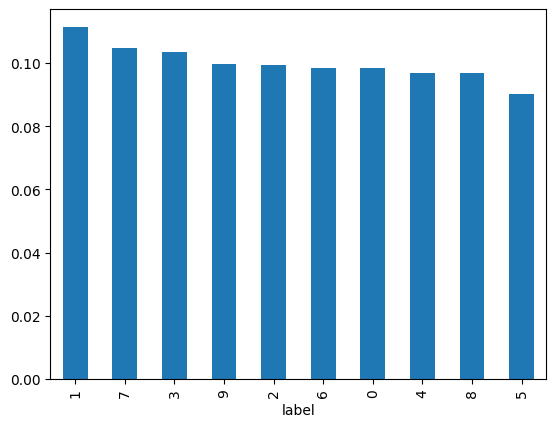

In [6]:
train_df.label.value_counts(normalize=True).plot.bar()

## Create dataset

In [7]:
class MNISTDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transform=None, target_transform=None):
        self.labels = np.zeros((len(dataframe)))
        if "label" in dataframe:
            self.labels = dataframe.label.values
            dataframe = dataframe.drop(labels=["label"], axis=1)
        self.images = dataframe.values.reshape((len(self.labels), 28, 28)).astype(np.uint8)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = np.expand_dims(self.images[idx], axis=-1)
        image = np.repeat(image, 3, axis=-1)
        image = transforms.ToTensor()(image)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [13]:
augmentation = transforms.Compose(
    [
        transforms.RandomRotation(20),
        transforms.RandomPerspective(distortion_scale=0.6, p=1.0)
    ]
)

train_ds = MNISTDataset(train_df, transform=augmentation)
val_ds = MNISTDataset(val_df)
test_ds = MNISTDataset(test_df)

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

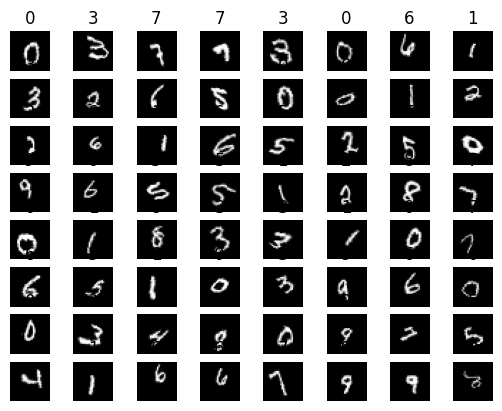

In [14]:
train_sample_image_batch, train_sample_label_batch = next(iter(train_dataloader))

for i, image in enumerate(train_sample_image_batch):
    plt.subplot(BATCH_SIZE // 8, 8, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(train_sample_label_batch[i].numpy())
    plt.axis("off")

## Create model

In [15]:
class SimpleCNN(nn.Module):
    """Some Information about SimpleCNN"""
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.stack = [128, 256, 512]
        
        self.layers = nn.Sequential(
            nn.Conv2d(3, self.stack[0], 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.stack[0], self.stack[0], 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(self.stack[0]),
            nn.Conv2d(self.stack[0], self.stack[1], 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.stack[1], self.stack[1], 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(self.stack[1]),
            nn.Conv2d(self.stack[1], self.stack[2], 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.stack[2], self.stack[2], 3),
            nn.ReLU(),
            nn.BatchNorm2d(self.stack[2]),
            nn.Flatten(),
            nn.Linear(self.stack[2] * 3**2, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):    
        return self.layers(x)

model = SimpleCNN()
model.to(device)
torchsummary.summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           3,584
              ReLU-2          [-1, 128, 28, 28]               0
            Conv2d-3          [-1, 128, 26, 26]         147,584
              ReLU-4          [-1, 128, 26, 26]               0
         MaxPool2d-5          [-1, 128, 13, 13]               0
       BatchNorm2d-6          [-1, 128, 13, 13]             256
            Conv2d-7          [-1, 256, 13, 13]         295,168
              ReLU-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 256, 11, 11]         590,080
             ReLU-10          [-1, 256, 11, 11]               0
        MaxPool2d-11            [-1, 256, 5, 5]               0
      BatchNorm2d-12            [-1, 256, 5, 5]             512
           Conv2d-13            [-1, 512, 5, 5]       1,180,160
             ReLU-14            [-1, 51

In [17]:
torch.autograd.set_detect_anomaly(True)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2)

EPOCHS = 50

best_loss = 99999

print("Started training...")
for epoch in range(EPOCHS):
    train_loss, val_loss = 0.0, 0.0
    train_accuracy, val_accuracy = 0.0, 0.0
    
    curr_lr = optimizer.param_groups[0]['lr']
    
    i = 0
    
    model.train()
    for data, label in train_dataloader:
        if torch.cuda.is_available():
            data, label = data.cuda(), label.cuda()
            
        i += 1

        optimizer.zero_grad()
        target = model(data)
        train_step_loss = loss(target, label)
        train_step_loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        train_loss += train_step_loss.item()
        train_accuracy += torch.sum(torch.argmax(target, dim=1) == label) / len(target)
        
        print(f'\r[{epoch + 1}] ({i}/{len(train_dataloader)}) lr: {curr_lr}, loss: {train_loss / i:.3f}, accuracy: {train_accuracy / i:.3f}', end='\x1b[2K')

    # Set model to Evaluation mode
    model.eval()
    for data, label in val_dataloader:
        if torch.cuda.is_available():
            data, label = data.cuda(), label.cuda()

        target = model(data)
        val_step_loss = loss(target, label)

        val_loss += val_step_loss.item()
        val_accuracy += torch.sum(torch.argmax(target, dim=1) == label) / len(target)
    
    val_mean_loss = val_loss / len(val_dataloader)

    if val_mean_loss < best_loss:
        torch.save(model.state_dict(), "./model.pt")
        best_loss = val_mean_loss
    
    print(f' - val_loss: {val_mean_loss:.3f}, val_accuracy: {val_accuracy / len(val_dataloader):.3f}')
    
    scheduler.step(val_mean_loss)

print('Finished Training')

Started training...
[1] (33/558) lr: 0.0001, loss: 2.006, accuracy: 0.480

KeyboardInterrupt: 

In [ ]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.cuda(), labels.cuda()

outputs = model(inputs)
predictions = np.argmax(outputs.detach().cpu().numpy(), axis=1)
print(predictions)
print(labels.detach().cpu().numpy())

for i, image in enumerate(inputs):
    plt.subplot(2, 8, i + 1)
    plt.imshow(image.cpu().permute(1, 2, 0))
    plt.title(predictions[i])
    plt.axis("off")


In [ ]:
predictions = np.array([])

for i, data in enumerate(test_dataloader, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()

    outputs = model(inputs)
    predictions = np.append(predictions, torch.argmax(outputs, dim=1).cpu().numpy())

predictions

In [ ]:
submission_df = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
submission_df.Label = predictions.astype(np.uint8)
submission_df.to_csv("./submission.csv", index=False)
submission_df.head()

In [ ]:
torch.save(model.state_dict(), "./model.pt")